# Dataset Generation

From https://www.mrlc.gov/data/nlcd-land-cover-conus-all-years

In [1]:
import geopandas
import random
from shapely.geometry import Point, Polygon, MultiPolygon
import rasterio
import matplotlib.pyplot as plt
import fiona.transform
from zipfile import ZipFile, ZIP_DEFLATED, ZIP_LZMA
import numpy as np
import io
import pandas as pd
import sqlite3

random.seed(320)

## Read State Shape file

In [2]:
city = {"madison":Point(-89.39,43.08),
        "milwaukee":Point(-87.97,43.06),
        "greenbay":Point(-87.99,44.52),
        "kenosha":Point(-87.87,42.59),
        "racine":Point(-87.81,42.73),
        "appleton":Point(-88.39,44.28),
        "waukesha":Point(-88.25,43.01),
        "oshkosh":Point(-88.56,44.02),
        "eauclaire":Point(-91.49,44.82),
        "janesville":Point(-89.01,42.69),
       }

In [3]:
cong = geopandas.read_file("zip://data/cb_2018_us_cd116_20m.zip")
wi = cong[cong["STATEFP"] == "55"]
wi.head(3)

,STATEFP,CD116FP,AFFGEOID,GEOID,LSAD,CDSESSN,ALAND,AWATER,geometry
89,55,06,5001600US5506,5506,C2,116,12740758652,7315844396,"POLYGON ((-89.78490 43.64105, -89.71873 43.643..."
92,55,04,5001600US5504,5504,C2,116,332617267,2454549243,"POLYGON ((-88.07030 43.12271, -88.07021 43.125..."
131,55,08,5001600US5508,5508,C2,116,17629673120,8180685289,"MULTIPOLYGON (((-86.93428 45.42115, -86.83575 ..."


In [4]:
sample_size_per_district = 250
points = []
for row in wi.itertuples():
    district, shape = row.CD116FP, row.geometry
    minx, miny, maxx, maxy = shape.bounds

    i = 0
    while i < sample_size_per_district:
        pt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if not shape.contains(pt):
            continue
        points.append({"lon": pt.x, "lat": pt.y, "district": "district " + district, "geometry": pt})
        i += 1
sample = geopandas.GeoDataFrame(points).sample(frac=1).reset_index(drop=True).set_crs(wi.crs)
sample.head(3)

,lon,lat,district,geometry
0,-91.094093,43.750081,district 03,POINT (-91.09409 43.75008)
1,-88.441833,44.206438,district 06,POINT (-88.44183 44.20644)
2,-90.757041,45.801727,district 07,POINT (-90.75704 45.80173)


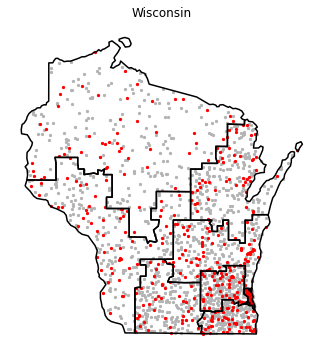

In [5]:
ax = wi.boundary.plot(color="black", figsize=(6,6))
sample.iloc[400:].plot(ax=ax, markersize=5, color="0.7")
sample.iloc[:400].plot(ax=ax, markersize=5, color="red")
plt.axis("off")
plt.title("Wisconsin")
plt.show()

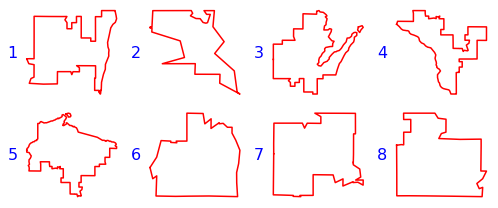

In [6]:
num_rows = 2
num_cols = 4

fig, ax_ll = plt.subplots(num_rows, num_cols, figsize=(7,3))

for i in range(num_rows):
    for j in range(num_cols):
        ax = ax_ll[i][j]
        polygon = wi.iloc[i * num_cols + j]["geometry"]

        # Some districts are Multipolygons
        if isinstance(polygon, MultiPolygon):
            for geom in polygon.geoms:
                x, y = geom.exterior.xy
                ax.plot(x, y, color="r")
        else:
            x, y = polygon.exterior.xy
            ax.plot(x, y, color="r")
            
        ax.axis("off")
        ax.text(-0.1, 0.5, i * num_cols + j + 1, size=16,
            verticalalignment="center", horizontalalignment="center",
            transform=ax.transAxes, color="b")
        
plt.tight_layout()
plt.savefig("imgs/congressional_districts.png", dpi=150)
plt.show()

## Extract area coded images corresponding to Points

In [7]:
# data: https://www.mrlc.gov/data/nlcd-land-cover-conus-all-years

import time

def get_map(raster, pt, radius):
    # raster coords to cell
    x,y = raster.index(pt.x, pt.y)
    return raster.read(window=((x-radius,x+radius),(y-radius,y+radius)))

t0 = time.time()

with ZipFile(f"data/images.zip", "w", compression=ZIP_LZMA) as zf:
    path = f"zip://data/NLCD_2016_Land_Cover_L48_20190424.zip!NLCD_2016_Land_Cover_L48_20190424.img"

    with rasterio.open(path) as raster:
        sample = sample.to_crs(raster.crs).copy()
        sample["file_name"] = None
        for i in sample.index:
            if i % 100 == 0:
                print(i, sample.at[i, "geometry"])
            radius = 50
            m = get_map(raster, sample.at[i, "geometry"], radius=radius)
            fname = f"area{str(i).zfill(4)}.npy"
            with zf.open(fname, "w") as img_file:
                np.save(img_file, m[0,:,:])
            sample.at[i, "file_name"] = fname

t1 = time.time()
print("SEC", t1-t0)

0 POINT (393321.9714785019 2316597.53549148)
100 POINT (561818.5037173969 2485948.084356679)
200 POINT (603855.3791216215 2234614.093456469)
300 POINT (504604.6381423076 2355962.035228188)
400 POINT (580045.4374444548 2243406.488280065)
500 POINT (653884.5213431388 2244448.759502007)
600 POINT (644521.7848794134 2382051.529384815)
700 POINT (649881.8963761141 2254180.453057267)
800 POINT (660209.1371172647 2233097.167066256)
900 POINT (640023.0834847988 2264762.774733728)
1000 POINT (609191.3724844048 2268000.123778353)
1100 POINT (571490.163583217 2288114.046013239)
1200 POINT (495069.5857372688 2221888.24096302)
1300 POINT (419972.5363922916 2633132.885216951)
1400 POINT (450562.0494884823 2293474.944248126)
1500 POINT (659325.2218050777 2244888.262530765)
1600 POINT (650364.47960169 2267733.275017012)
1700 POINT (536176.9587605959 2457760.8235028)
1800 POINT (593758.6826164369 2368556.107742039)
1900 POINT (630072.1288301667 2224909.805964118)
SEC 76.97255516052246


In [8]:
sample

,lon,lat,district,geometry,file_name
0,-91.094093,43.750081,district 03,POINT (393321.971 2316597.535),area0000.npy
1,-88.441833,44.206438,district 06,POINT (601548.771 2381270.124),area0001.npy
2,-90.757041,45.801727,district 07,POINT (407723.121 2546097.341),area0002.npy
3,-88.234996,44.788954,district 08,POINT (612677.136 2447273.379),area0003.npy
4,-87.954035,43.078655,district 04,POINT (650924.698 2259060.497),area0004.npy
...,...,...,...,...,...
1995,-88.960584,42.591088,district 01,POINT (573685.498 2198265.761),area1995.npy
1996,-88.530275,42.714524,district 01,POINT (607600.665 2214696.294),area1996.npy
1997,-89.828437,45.408001,district 07,POINT (482682.039 2506778.439),area1997.npy
1998,-91.276886,43.994077,district 03,POINT (377327.114 2343037.686),area1998.npy


## Create images.db

In [9]:
district_tbl = pd.DataFrame([
    [103, "district 01"],
    [999, "district 02"],
    [321, "district 03"],
    [12, "district 04"],
    [234, "district 05"],
    [25, "district 06"],
    [1024, "district 07"],
    [500, "district 08"],
], columns=["district_id", "district_name"])

lookup = dict(district_tbl.set_index("district_name")["district_id"])
sample["district_id"] = sample["district"].apply(lambda name: lookup[name])
for col in ["water_ratio", "forest_ratio", "agriculture_ratio", "developed_ratio"]:
    sample[col] = None

In [10]:
sample.head(3)

,lon,lat,district,geometry,file_name,district_id,water_ratio,forest_ratio,agriculture_ratio,developed_ratio
0,-91.094093,43.750081,district 03,POINT (393321.971 2316597.535),area0000.npy,321,None,None,None,None
1,-88.441833,44.206438,district 06,POINT (601548.771 2381270.124),area0001.npy,25,None,None,None,None
2,-90.757041,45.801727,district 07,POINT (407723.121 2546097.341),area0002.npy,1024,None,None,None,None


In [11]:
with sqlite3.connect(f"data/images.db") as c:
    district_tbl.to_sql("districts", c, index=False, if_exists="replace")
    tbl = sample[["file_name", "lon", "lat", "district_id", "water_ratio", "forest_ratio", "agriculture_ratio"]]
    tbl.to_sql("sample", c, index=False, if_exists="replace")

## Show sample area

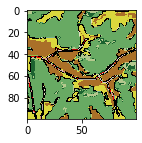

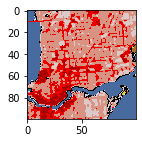

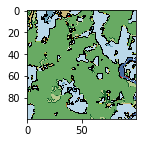

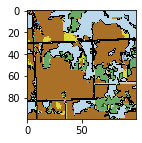

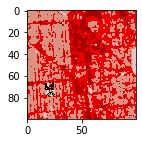

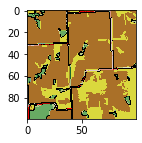

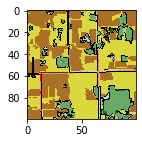

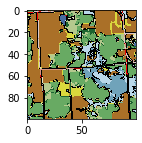

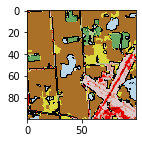

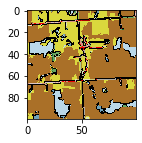

In [12]:
from matplotlib.colors import ListedColormap
use_cmap = np.zeros(shape=(256,4))
use_cmap[:,-1] = 1
uses = np.array([
    [0, 0.00000000000, 0.00000000000, 0.00000000000],
    [11, 0.27843137255, 0.41960784314, 0.62745098039],
    [12, 0.81960784314, 0.86666666667, 0.97647058824],
    [21, 0.86666666667, 0.78823529412, 0.78823529412],
    [22, 0.84705882353, 0.57647058824, 0.50980392157],
    [23, 0.92941176471, 0.00000000000, 0.00000000000],
    [24, 0.66666666667, 0.00000000000, 0.00000000000],
    [31, 0.69803921569, 0.67843137255, 0.63921568628],
    [41, 0.40784313726, 0.66666666667, 0.38823529412],
    [42, 0.10980392157, 0.38823529412, 0.18823529412],
    [43, 0.70980392157, 0.78823529412, 0.55686274510],
    [51, 0.64705882353, 0.54901960784, 0.18823529412],
    [52, 0.80000000000, 0.72941176471, 0.48627450980],
    [71, 0.88627450980, 0.88627450980, 0.75686274510],
    [72, 0.78823529412, 0.78823529412, 0.46666666667],
    [73, 0.60000000000, 0.75686274510, 0.27843137255],
    [74, 0.46666666667, 0.67843137255, 0.57647058824],
    [81, 0.85882352941, 0.84705882353, 0.23921568628],
    [82, 0.66666666667, 0.43921568628, 0.15686274510],
    [90, 0.72941176471, 0.84705882353, 0.91764705882],
    [95, 0.43921568628, 0.63921568628, 0.72941176471],
])
for row in uses:
    use_cmap[int(row[0]),:-1] = row[1:]
use_cmap = ListedColormap(use_cmap)

def show_img(name):
    plt.figure(figsize = (2,2))
    with ZipFile(f"data/images.zip") as zf:
        with zf.open(name) as f:
            buf = io.BytesIO(f.read())
            B = np.load(buf)
    plt.imshow(B, cmap=use_cmap, vmin=0, vmax=255)
    return B
for i in range(10):
    show_img(f"area{str(i).zfill(4)}.npy")